In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec

from urllib import urlretrieve
import cPickle as pickle
import os
import gzip

import cv2
import numpy as np
import theano

import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum

from nolearn.lasagne import NeuralNet
from nolearn.lasagne import visualize

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from settings import *
from utils import *

'''
Good tutorial: http://nbviewer.jupyter.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb
'''

s = Settings()

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: no CUDA-capable device is detected)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


Settings: set image size to:  21


Got 1735 files for label Tobi
Got 3072 files for label Mariam
Got 508 files for label Other
Got 4130 files for label Negative


utils.py:56: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_test = X_train[0.8*X_train.shape[0]:]
utils.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y_test = y_train[0.8*y_train.shape[0]:]
utils.py:58: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_train = X_train[:0.8*X_train.shape[0]]
utils.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y_train = y_train[:0.8*y_train.shape[0]]


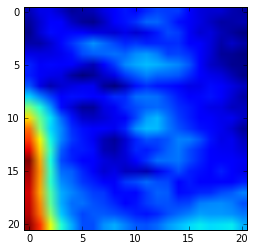

In [2]:
X_train,y_train,X_test,y_test  = load_faces(s, rgb=False)
plt.imshow(X_train[0][0])
plt.show()

In [11]:
net1 = s.net
net1.initialize()
# ATTENTION ! -> only if we do not want to train
net1.load_weights_from(s.net_name)
# show how this net looks like

Loaded parameters to layer 'conv2d1' (shape 16x1x5x5).
Loaded parameters to layer 'conv2d1' (shape 16).
Loaded parameters to layer 'conv2d2' (shape 16x16x5x5).
Loaded parameters to layer 'conv2d2' (shape 16).
Loaded parameters to layer 'dense' (shape 64x251).
Loaded parameters to layer 'dense' (shape 251).
Loaded parameters to layer 'output' (shape 251x4).
Loaded parameters to layer 'output' (shape 4).


/usr/local/lib/python2.7/dist-packages/nolearn/lasagne/base.py:734: UserWarning: The 'load_weights_from' method will be removed in nolearn 0.6. Please use 'load_params_from' instead.
  warn("The 'load_weights_from' method will be removed in nolearn 0.6. "


In [12]:
# print layer info
from nolearn.lasagne import PrintLayerInfo
layer_info = PrintLayerInfo()
net1.verbose = 3
layer_info, legend = layer_info._get_layer_info_conv(net1)
print layer_info

name      size        total    cap.Y    cap.X    cov.Y    cov.X    filter Y    filter X    field Y    field X
--------  --------  -------  -------  -------  -------  -------  ----------  ----------  ---------  ---------
input     1x21x21       441   100.00   100.00   100.00   100.00          21          21         21         21
conv2d1   16x17x17     4624   100.00   100.00    23.81    23.81           5           5          5          5
maxpool1  16x8x8       1024   100.00   100.00    23.81    23.81           5           5          5          5
conv2d2   16x4x4        256    76.92    76.92    61.90    61.90          10          10         13         13
maxpool2  16x2x2         64    76.92    76.92    61.90    61.90          10          10         13         13
dropout1  16x2x2         64   100.00   100.00   100.00   100.00          21          21         21         21
dense     251           251   100.00   100.00   100.00   100.00          21          21         21         21
dropout2  

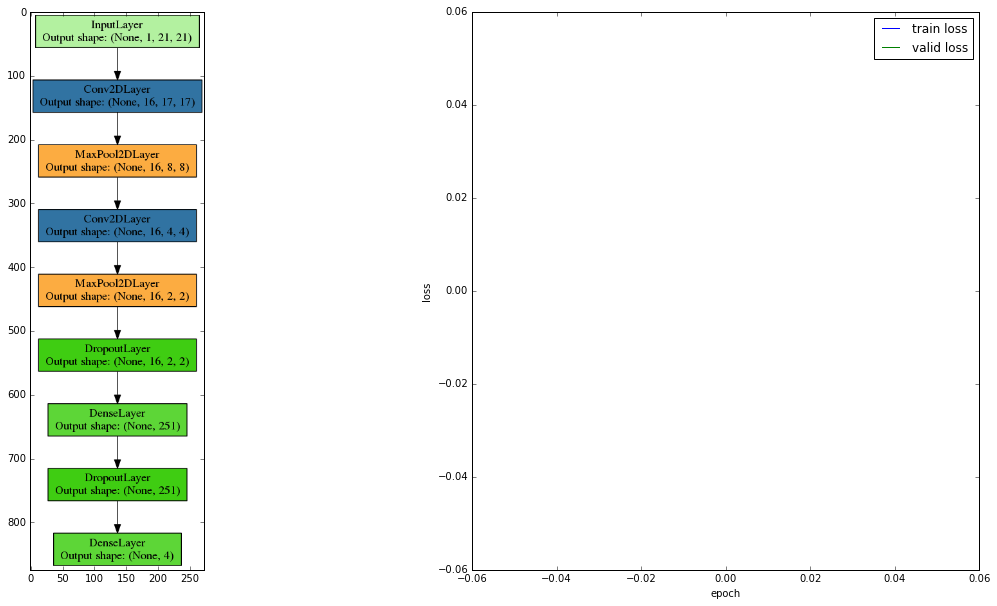

In [13]:
########### TRAINING !
#nn = net1.fit(X_train, y_train)
#net1.save_weights_to('facerecognet')

# visualize
from nolearn.lasagne import visualize
from nolearn.lasagne.visualize import draw_to_notebook, draw_to_file

fig = plt.figure(figsize=(20,10))
fig.add_subplot(121)
draw_to_file(net1, "/tmp/nn_tmp.png", output_shape=True)
tmp_img = cv2.cvtColor(cv2.imread("/tmp/nn_tmp.png"), cv2.COLOR_BGR2RGB)
#img = draw_to_notebook(net1, output_shape=True)
plt.imshow(tmp_img)
fig.add_subplot(122)
visualize.plot_loss(net1)
fig.savefig("test.png")

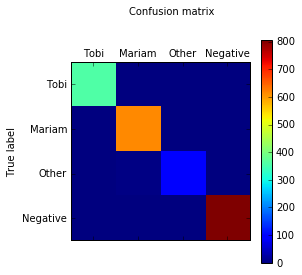

In [14]:
# Plot confiusion matrix
preds = net1.predict(X_test)

cm = confusion_matrix(y_test, preds)
plt.matshow(cm)
plt.suptitle('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.yticks(range(len(s.labels)), s.labels)
plt.xticks(range(len(s.labels)), s.labels)
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

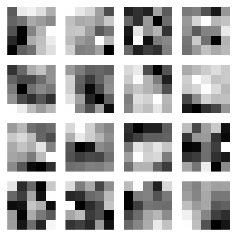

In [15]:
visualize.plot_conv_weights(net1.layers_[1], figsize=(4, 4))

Shape of conv2d1 layer weights:  (32, 3, 5, 5)


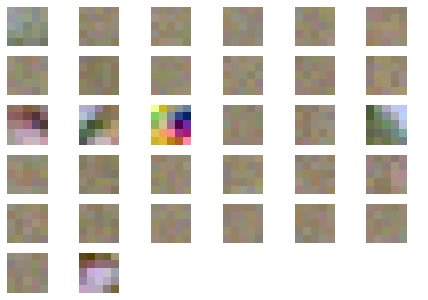

ValueError: num must be 1 <= num <= 512, not 513

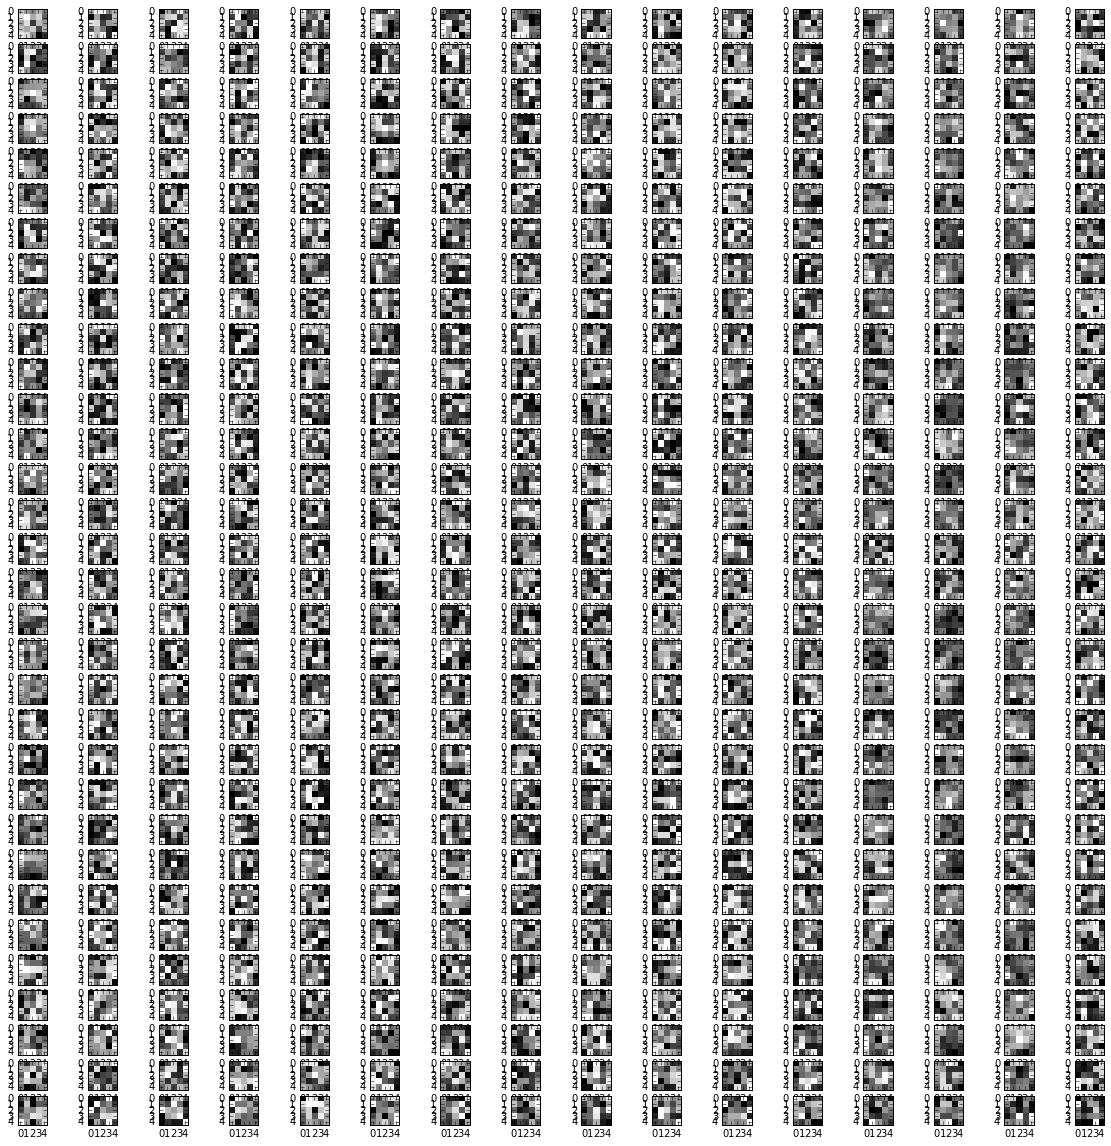

In [8]:
from matplotlib import pyplot as plt
import numpy as np


def make_conv_map(conv_weights,global_scale=False):
    shape = conv_weights.shape
    nrows = np.ceil(np.sqrt(shape[0])).astype(int)
    ncols = nrows
    fig, axes = plt.subplots(nrows, ncols)

    if global_scale:
        wmin,wmax = np.min(conv_weights,(0,2,3)),np.max(conv_weights,(0,2,3)) #seperate min and max per channel

    for i,ax in enumerate(axes.flatten()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')
        if i < shape[0]:
            w = conv_weights[i]
            if w.shape[0] > 3:
                w = np.sum(w, axis=0)[np.newaxis,:,:]
            w=np.squeeze(w.transpose(1,2,0))

            if not global_scale:
                wmin,wmax = np.min(w,(0,1)), np.max(w,(0,1)) #seperate min and max per channel

            w -= wmin
            w /= (wmax-wmin)
            ax.imshow(cv2.cvtColor(w, cv2.COLOR_BGR2RGB), interpolation='nearest', cmap='gray')
    fig.tight_layout(pad=0.1, w_pad=0.1, h_pad=1)
    return fig, axes

# show layer weights
fig = plt.figure(figsize=(20,20))
fig,axes = make_conv_map(net1.layers_['conv2d1'].W.get_value(), True)
print "Shape of conv2d1 layer weights: ", net1.layers_['conv2d1'].W.get_value().shape
plt.show()

fig = plt.figure(figsize=(20,20))
for j in range(net1.layers_['conv2d2'].W.get_value().shape[0]):
    values = net1.layers_['conv2d2'].W.get_value()[j]
    for i in range(len(values)):
        fig.add_subplot(net1.layers_['conv2d2'].W.get_value().shape[0],16,(j*16)+1+i)
        #ax.grid()
        #ax.set_xticks([])
        #ax.set_yticks([])
        plt.imshow(values[i], interpolation='nearest', cmap='gray')
plt.show()

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

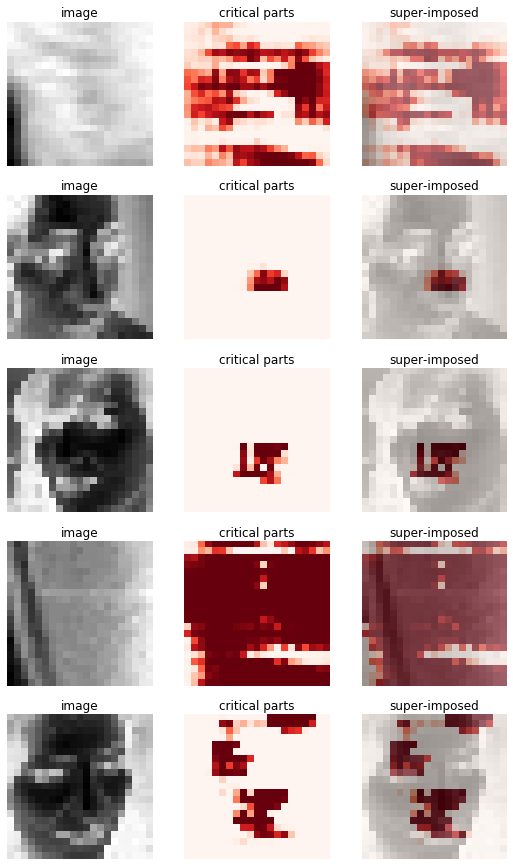

In [16]:
visualize.plot_occlusion(net1, X_train[:5], y_train[:5])

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

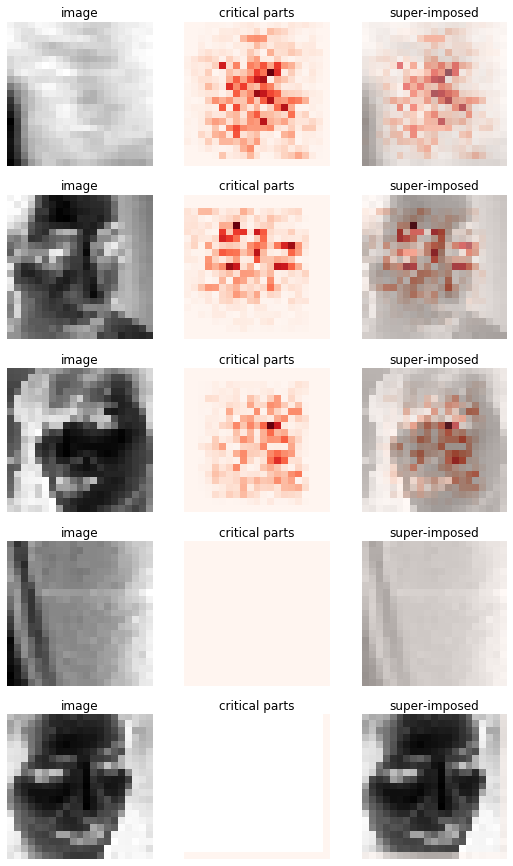

In [17]:
visualize.plot_saliency(net1, X_train[:5])

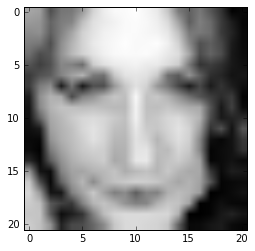

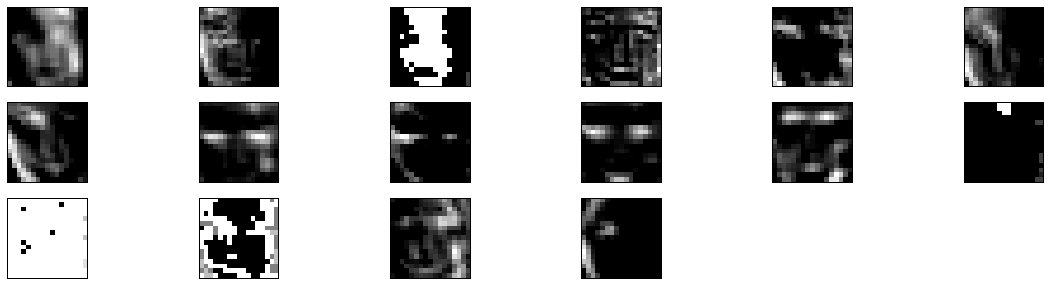

In [26]:
layers = net1.get_all_layers()
layer = layers[1]

fig = plt.figure()

try:
    plt.imshow(cv2.cvtColor(X_test[11].transpose(1,2,0).reshape(s.img_size, s.img_size,3), cv2.COLOR_BGR2RGB))
except:
    plt.imshow(X_test[11].reshape(s.img_size, s.img_size), cmap='gray')

fig = plt.figure(figsize=(20,10))
output = layer.get_output_for(np.array([X_test[11]])).eval()[0]
gs = gridspec.GridSpec(6, 6)
for i in range(layer.num_filters):
    g = gs[i]
    ax = plt.subplot(g)
    ax.grid()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(output[i], interpolation='nearest', cmap='gray')

<module 'matplotlib.pyplot' from '/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.pyc'>

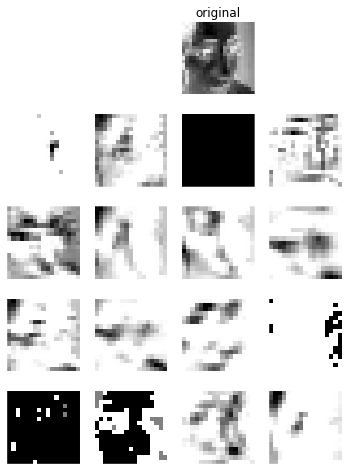

In [29]:
visualize.plot_conv_activity(net1.layers_[1], np.array([X_train[1]]))

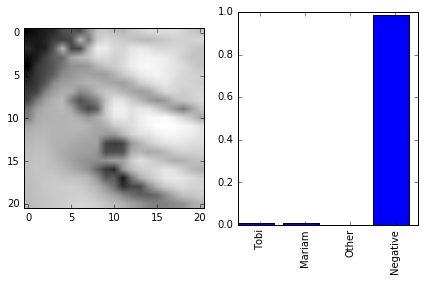

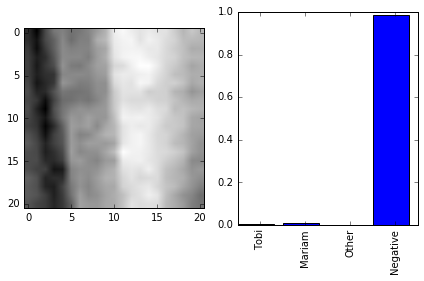

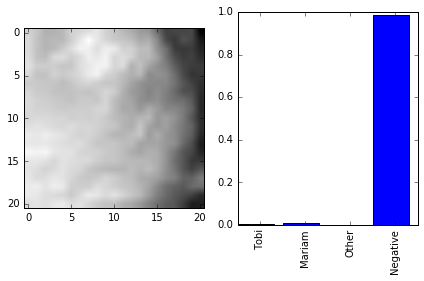

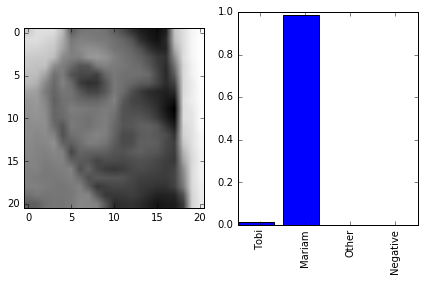

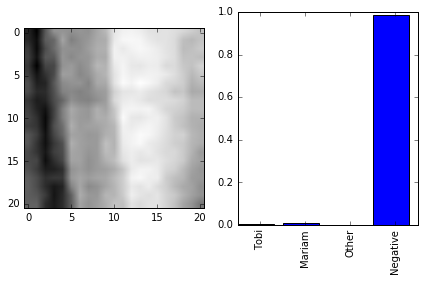

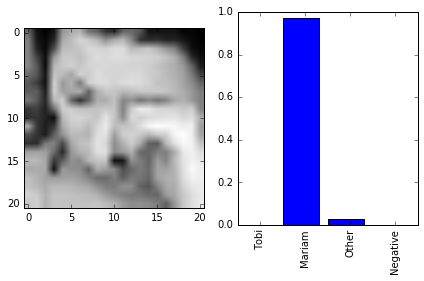

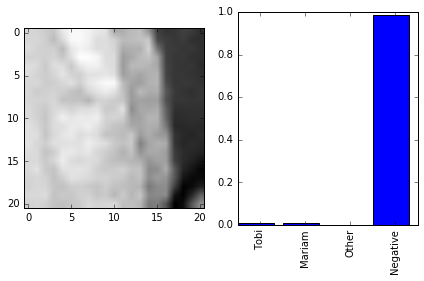

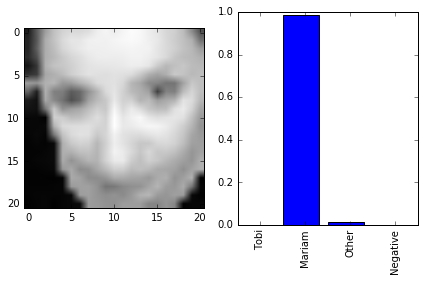

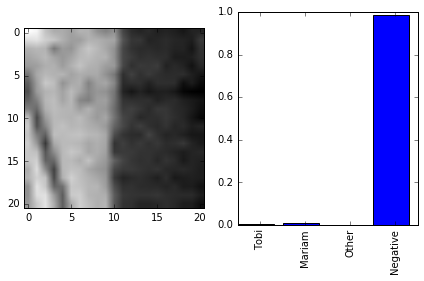

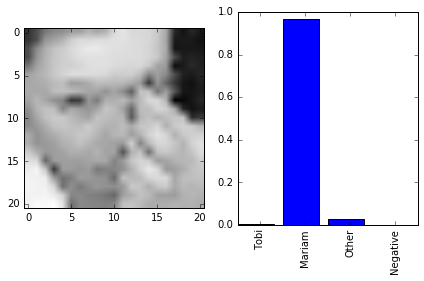

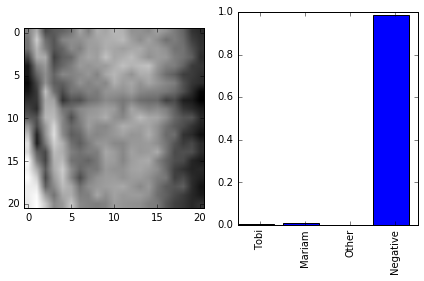

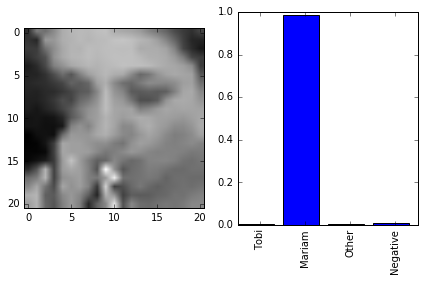

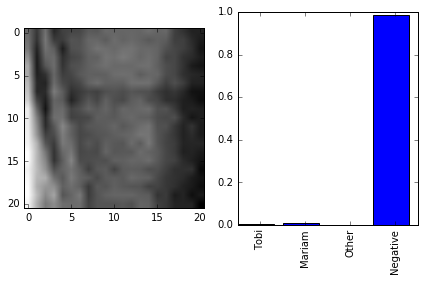

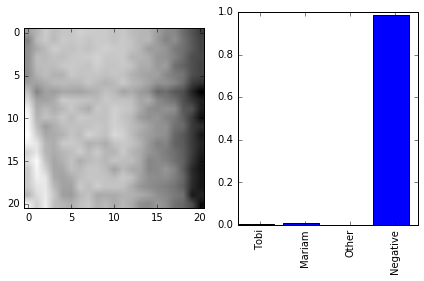

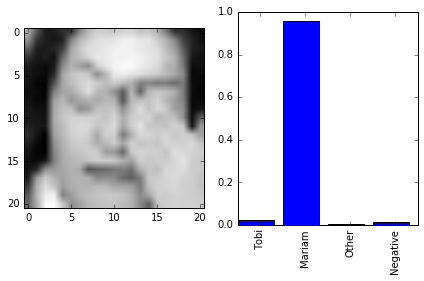

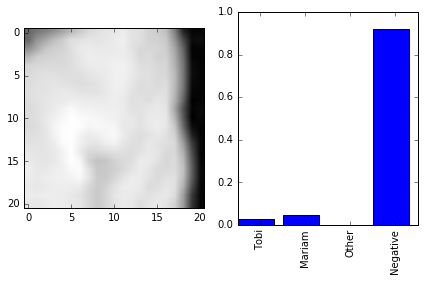

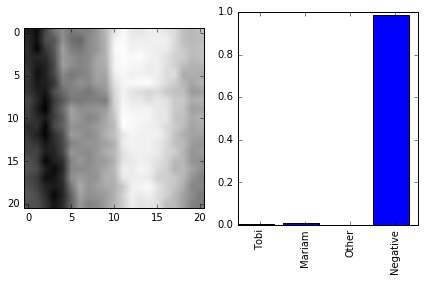

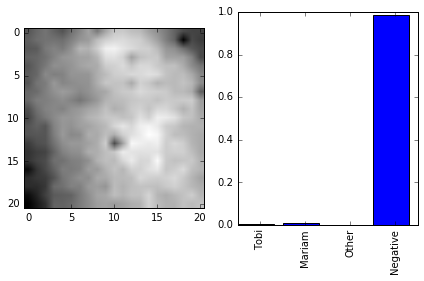

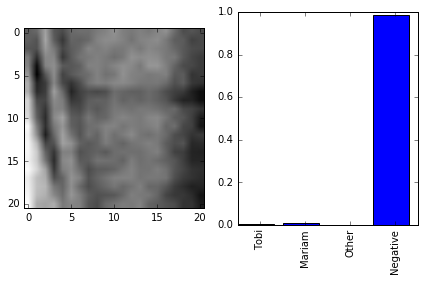

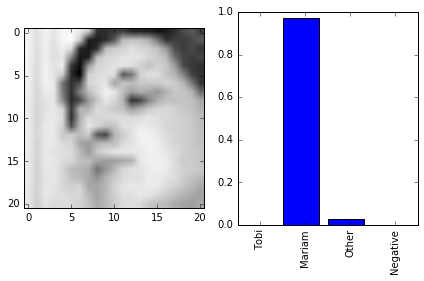

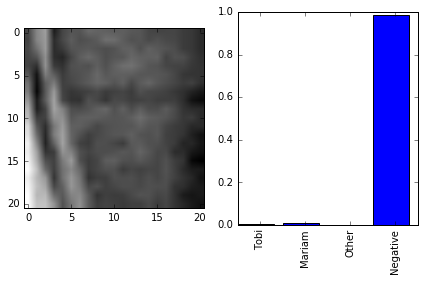

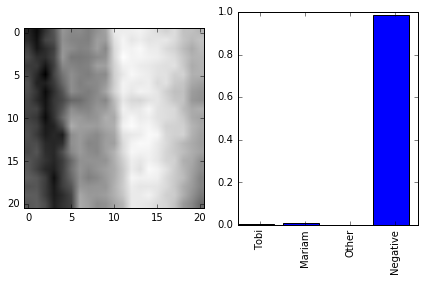

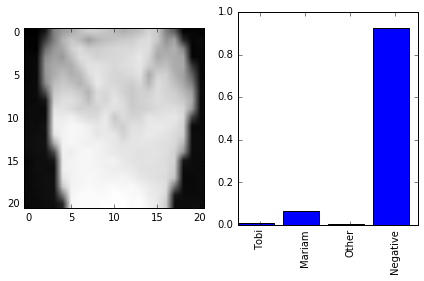

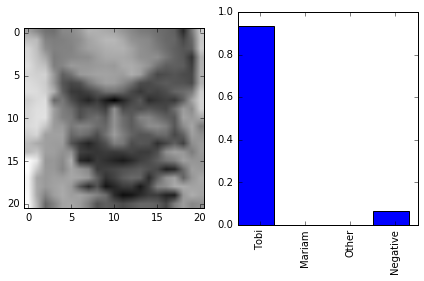

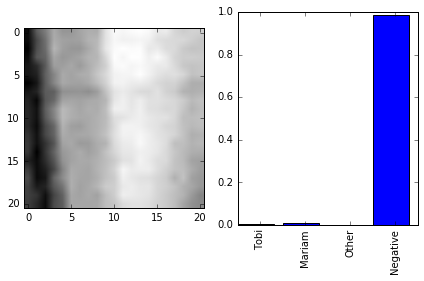

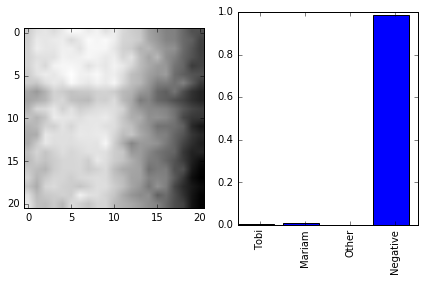

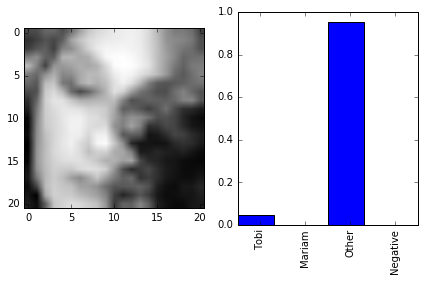

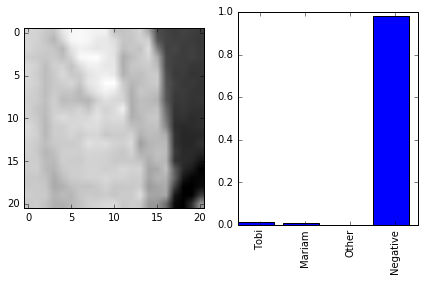

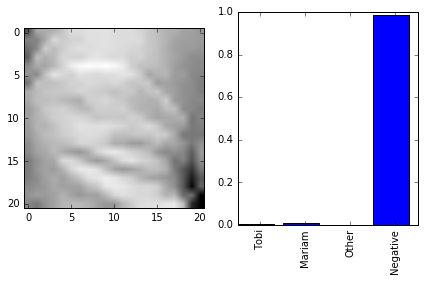

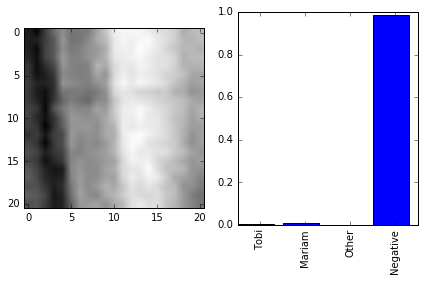

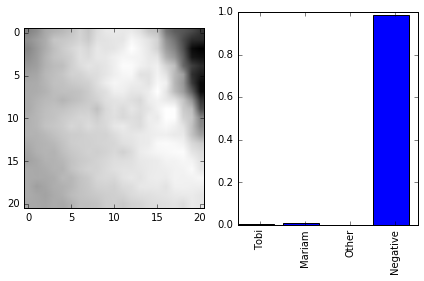

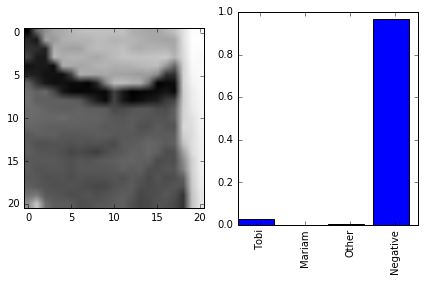

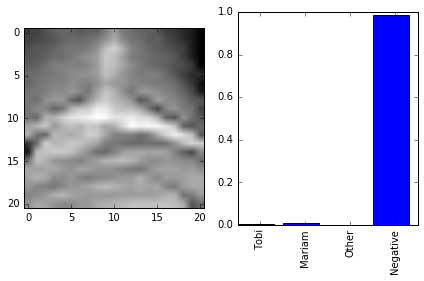

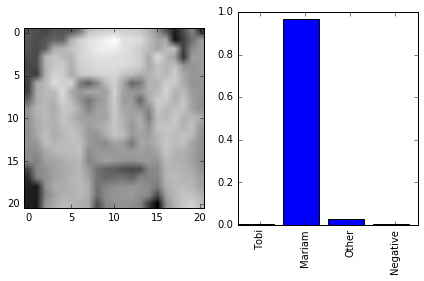

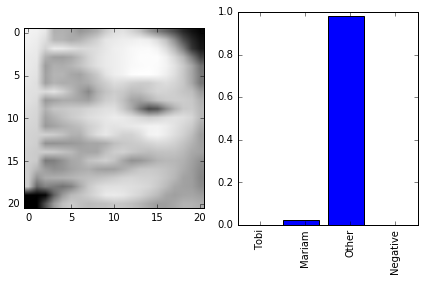

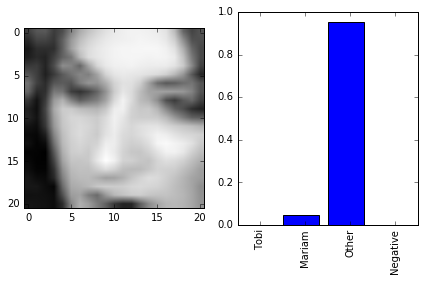

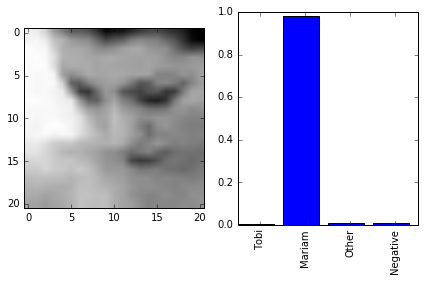

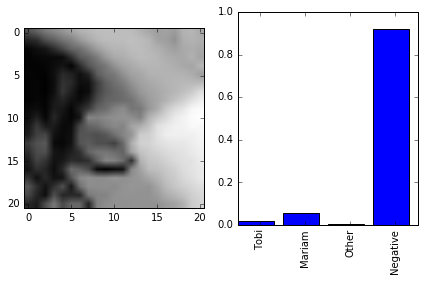

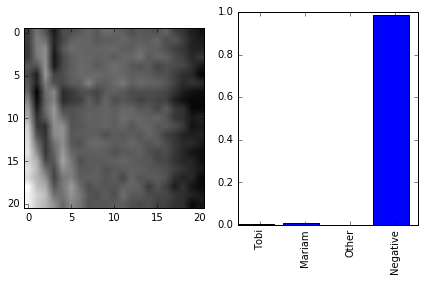

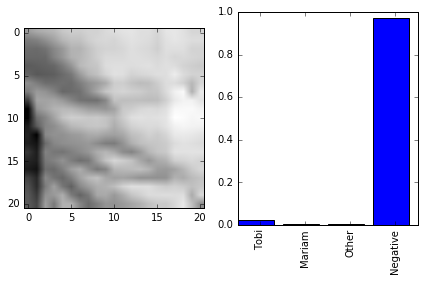

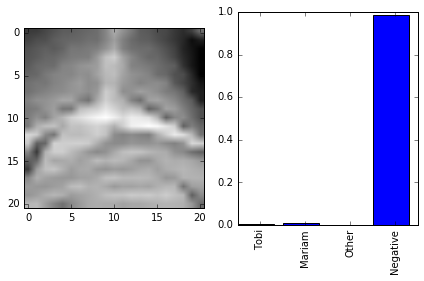

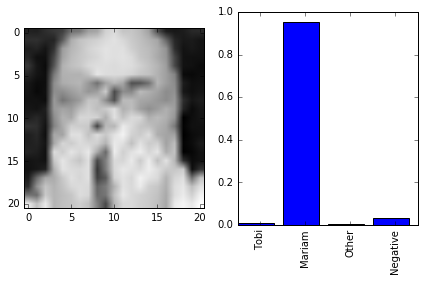

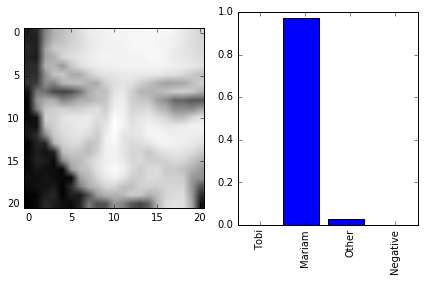

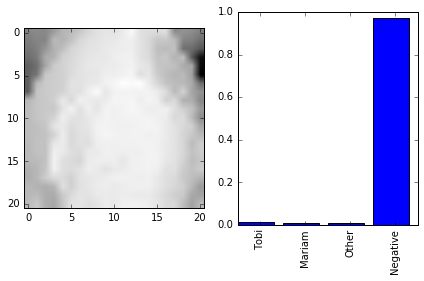

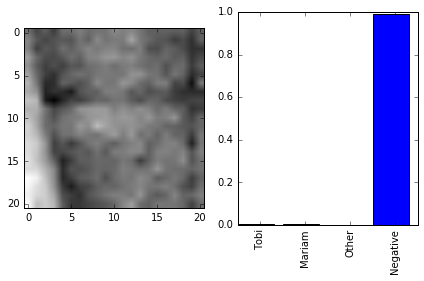

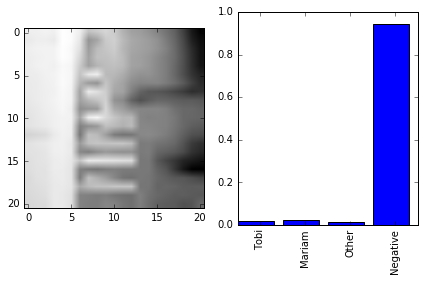

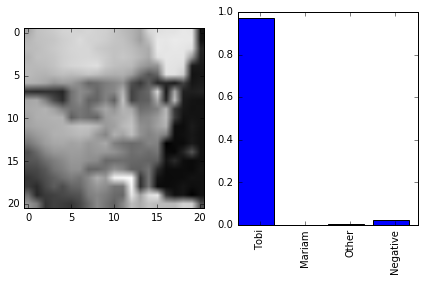

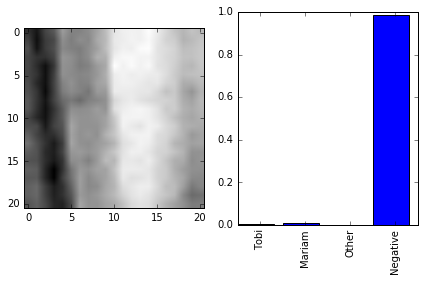

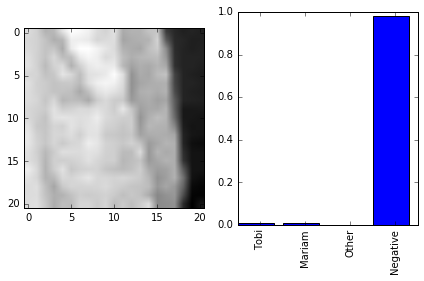

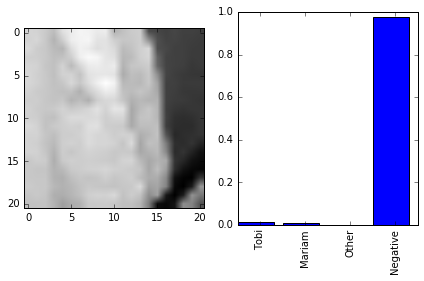

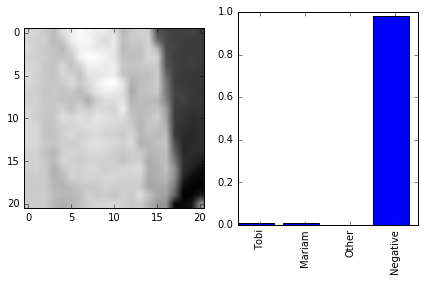

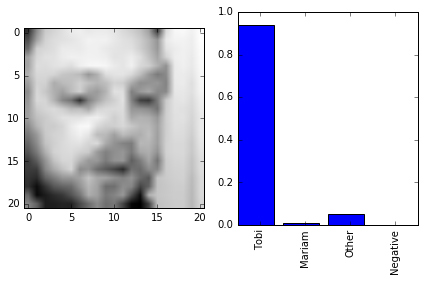

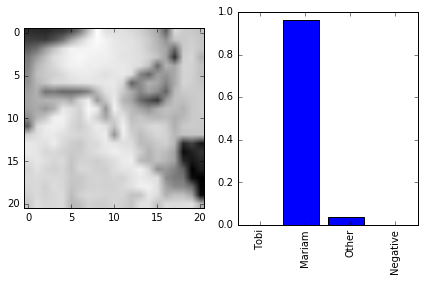

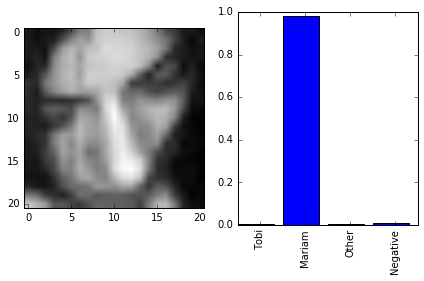

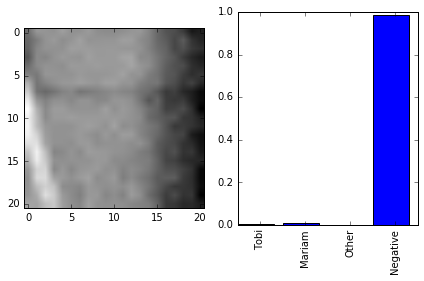

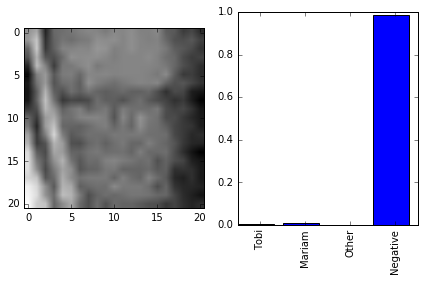

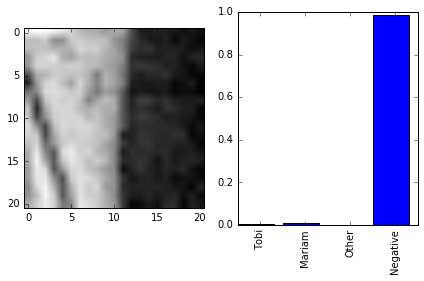

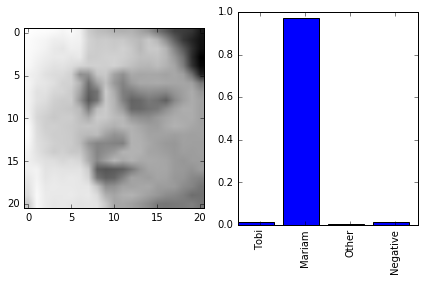

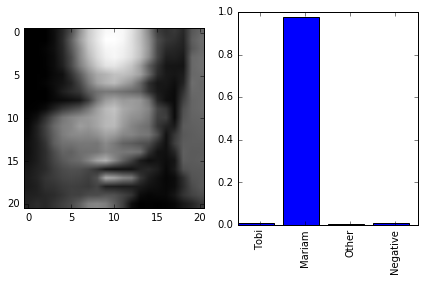

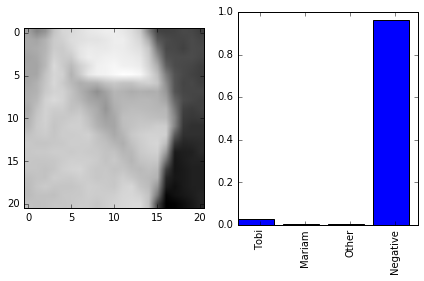

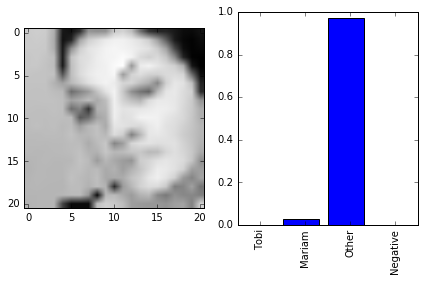

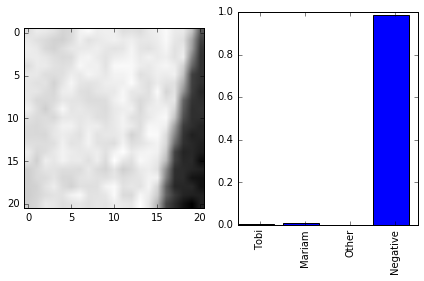

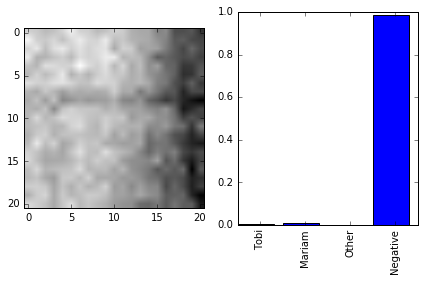

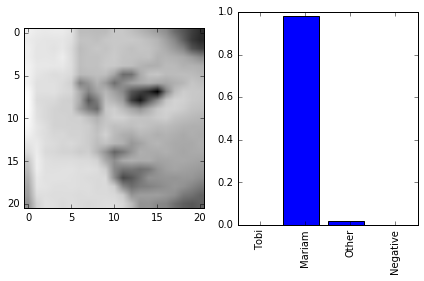

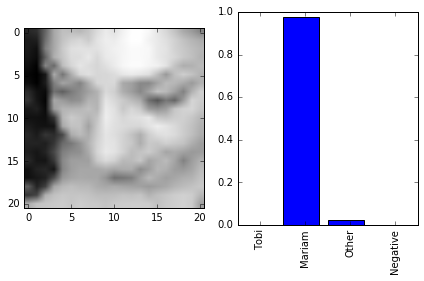

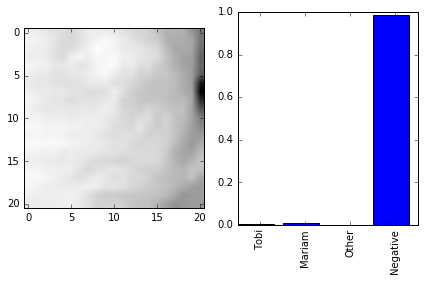

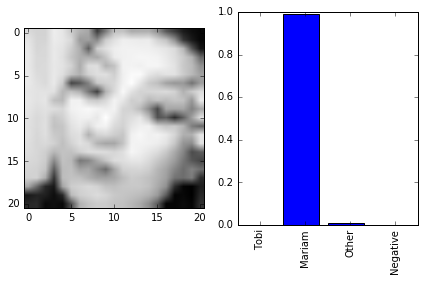

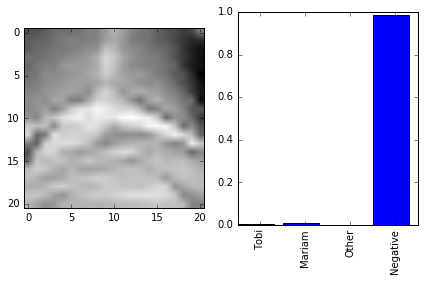

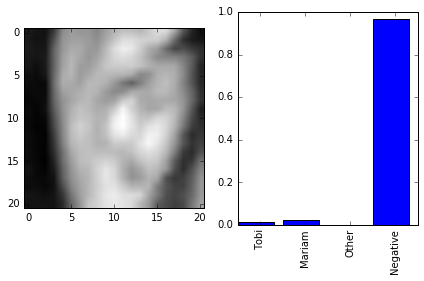

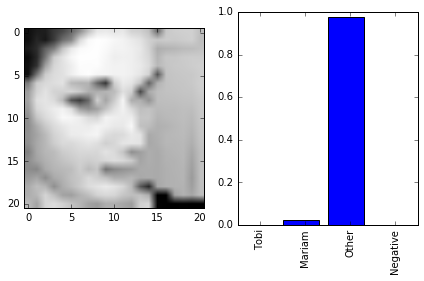

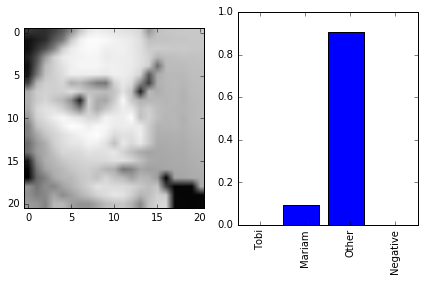

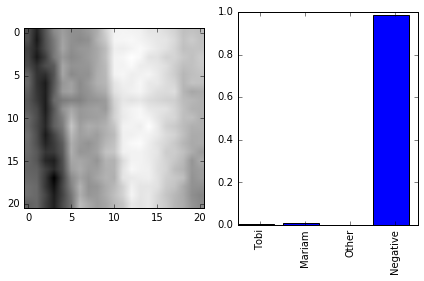

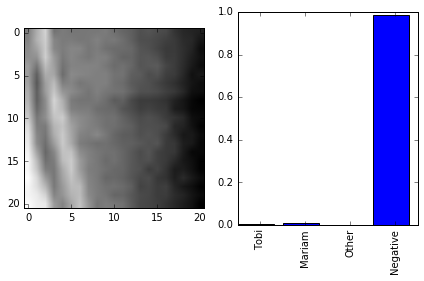

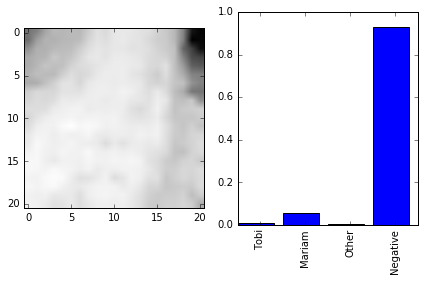

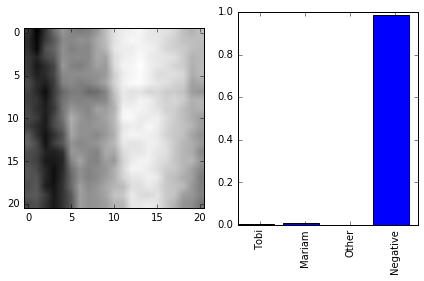

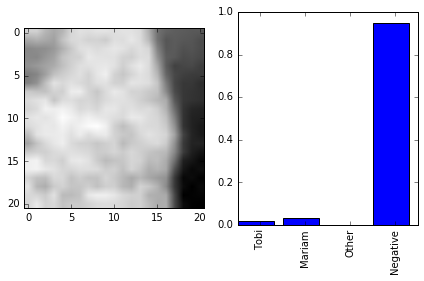

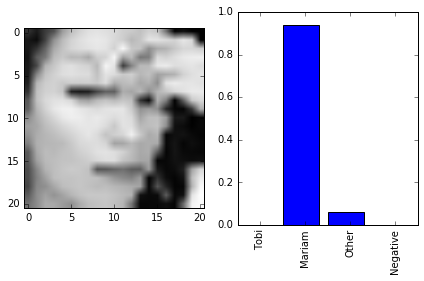

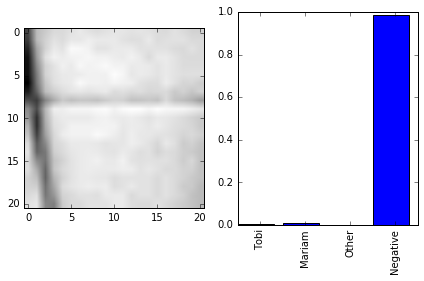

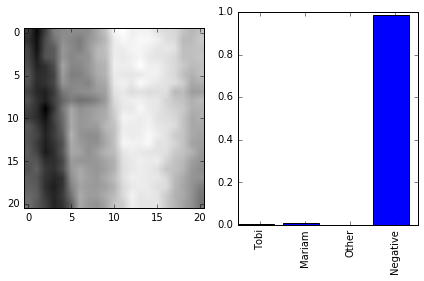

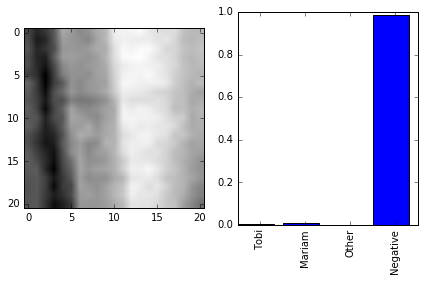

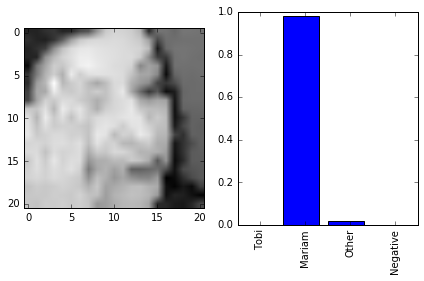

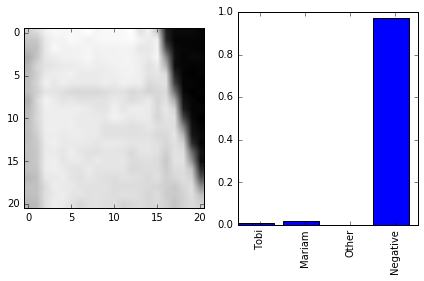

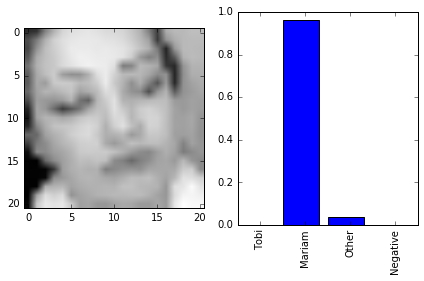

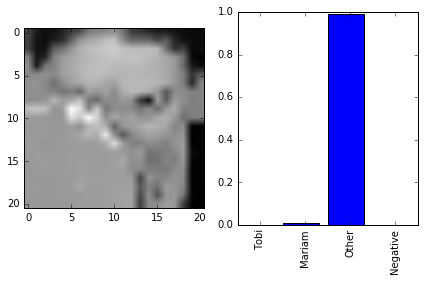

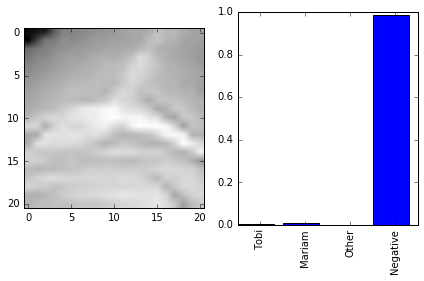

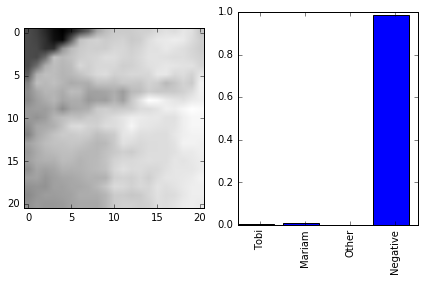

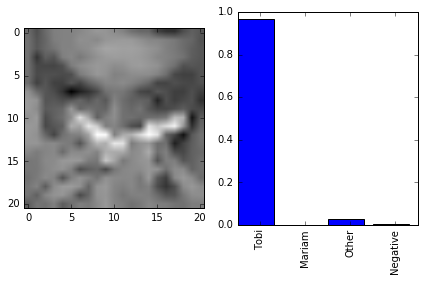

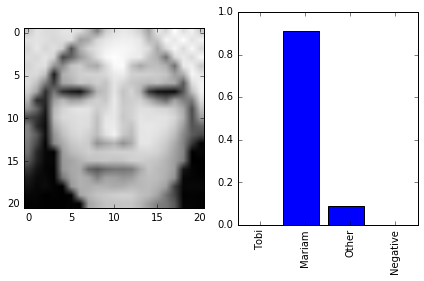

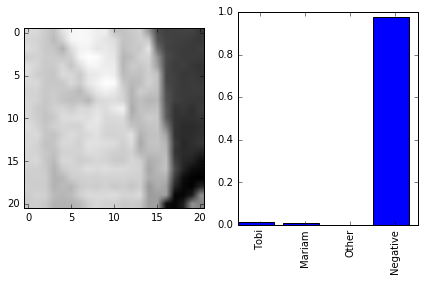

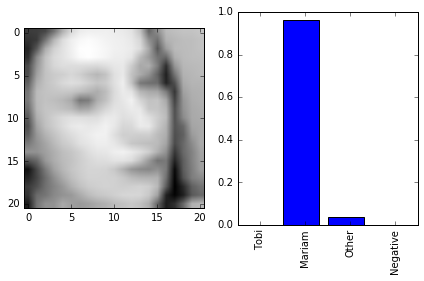

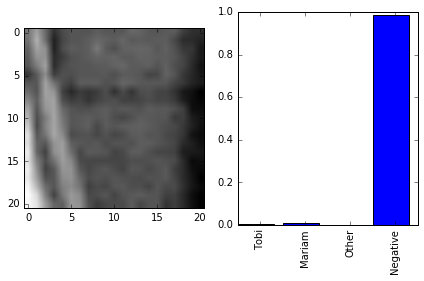

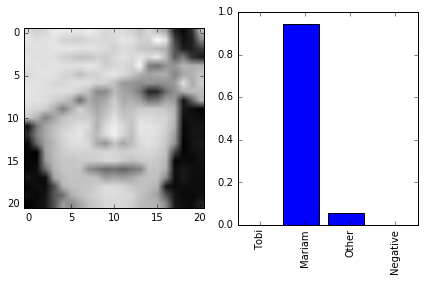

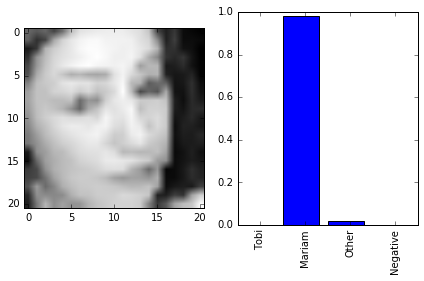

In [69]:
from lasagne import layers
dense_layer = layers.get_output(net1.layers_['dense'], deterministic=True)
output_layer = layers.get_output(net1.layers_['output'], deterministic=True)
input_var = net1.layers_['input'].input_var
f_output = theano.function([input_var], output_layer)
f_dense = theano.function([input_var], dense_layer)

# find an instance where the net is not sure
for i in range(X_test.shape[0]):
    instance = X_test[i][None, :, :]
    pred = f_output(instance)
    if np.max(pred) < 0.99 and np.max(pred) > 0.9:
        fig = plt.figure()
        fig.add_subplot(121)
        plt.imshow(instance[0][0], cmap='gray')

        fig.add_subplot(122)
        N = pred.shape[1]
        plt.bar(range(N), pred.ravel())

        plt.xticks([.5,1.5,2.5,3.5], s.labels, rotation='vertical')

        plt.tight_layout()

In [ ]:
# predict some specific faces and show the labels
import math
fig = plt.figure(figsize=(30,100))
nimages = 200
cols = 3
rows = math.ceil(nimages / float(cols))

for i in range(1,nimages+1):
    fig.add_subplot(rows,cols,i)
    query_img = X_test[np.random.randint(len(X_test))]
    pred = net1.predict(np.array(np.array([query_img])))
    plt.title("Prediction: label %s" % s.labels[pred])
    plt.imshow(cv2.cvtColor(query_img.transpose(1,2,0).reshape(s.img_size, s.img_size,3), cv2.COLOR_BGR2RGB))
plt.tight_layout()

In [ ]:
# measure how fast one forward-run (a prediction) is
import time
times = np.empty((0,1), np.float64)
for i in range(100):
    query_img = X_test[i]
    st = time.time()
    pred = net1.predict(np.array(np.array([query_img])))
    t = time.time() - st
    times = np.append(times, np.array([[t]]), axis=0)
print "Average time per prediciton: ", np.mean(times, axis=0)
print "That would give us %f fps" % (1. / np.mean(times, axis=0))
    

In [ ]:
# now check everything with resizing and shuffling channels etc
# take images from arbitrary label
files = glob.glob("./faces_120/Tobi/*.png")
times = np.empty((0,1), np.float64)
for f in files:
    st = time.time()
    img = cv2.resize(cv2.imread(f)/255., (s.img_size, s.img_size))
    img = img.transpose(2,0,1).reshape(3,s.img_size,s.img_size).astype(np.float32)
    net1.predict(np.array(np.array([img])))
    t = time.time() - st
    times = np.append(times, np.array([[t]]), axis=0)
print "Average time per prediciton: ", np.mean(times, axis=0)
print "That would give us %f fps" % (1. / np.mean(times, axis=0))